In [1]:
# Hacky but for now..
import sys
sys.path.append('../')

#external library imports:
import json
import time

import torch
from torch.utils.data import DataLoader

from tqdm import tqdm
from matplotlib import pyplot as plt

import torchvision
from torchvision import transforms


# Custom code imports
from lightning_trainer import LitModelTrainer
from generate_dreams.render_engine import generate_dream
from utils import rescale

In [2]:

plt.rcParams['figure.dpi'] = 300
# globals:
dataset = 'CIFAR'
# dataset = 'MNIST'

_batch_size = 256
_subset_size = 1 * _batch_size


# Model:
dream_model_loc = "../trained_models/CIFAR/base/version_0/checkpoints/model.ckpt"

torch_device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

cifar_loc = '../../../data/cifar'



In [3]:
# Load model checkpoint:
_checkpoint = LitModelTrainer.load_from_checkpoint(dream_model_loc)
dream_model = _checkpoint.model

c:\Users\stefa\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [4]:
_load_transform = transforms.Compose(
    [transforms.ToTensor()
    ])


In [5]:
_train_dataset = torchvision.datasets.CIFAR10(root=cifar_loc, train=True,
                                        download=True, transform=_load_transform)



dataloader = DataLoader(dataset=_train_dataset, batch_size=_batch_size, shuffle=False)



class_labels = ["airplanes", "cars", "birds", "cats", "deer", "dogs", "frogs", "horses", "ships", "trucks"]

Files already downloaded and verified


In [6]:
img_b = next(iter(dataloader))
_x, _y = img_b

_unique, _inverse = torch.unique(_y, return_inverse=True, dim=0)

_perm = torch.arange(_inverse.size(0), dtype=_inverse.dtype, device=_inverse.device)

_inverse, _perm = _inverse.flip([0]), _perm.flip([0])

_first_class_idxs = _inverse.new_empty(_unique.size(0)).scatter_(0, _inverse, _perm)

_dream_imgs = _x[_first_class_idxs]
_dream_lbl = torch.arange(0, 10, 1, device=torch_device)

img_b = (_dream_imgs, _dream_lbl)

allowed change 1.0
L2, Linf distances = 
 ['0.88', '1.22', '1.43', '1.07', '1.27', '1.21', '1.38', '1.36', '1.20', '1.39'] 
 ['0.04', '0.04', '0.04', '0.04', '0.04', '0.04', '0.04', '0.04', '0.04', '0.04']
mean l2 dist: 1.2411515593528748


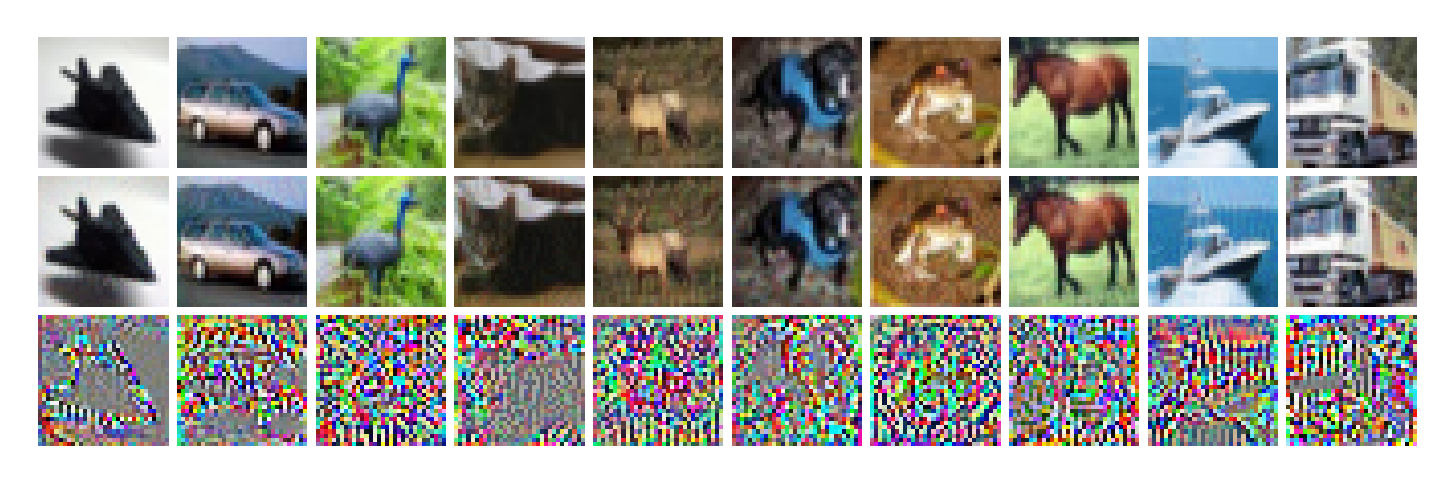

In [8]:
import numpy as np


tocpu = lambda t: t.detach().clone().cpu()

eps = 255/255

print(f"allowed change {eps}")

x, y = img_b
x, y = x.to(torch_device), y.to(torch_device)


imgs1 = generate_dream(model=dream_model, batch=img_b, device=torch_device, opt_lr=1e-2, iterations=(8,))[-1]

diff = torch.sub(x.to(torch_device), imgs1)
l2dist = torch.linalg.vector_norm(diff, ord=2, dim=(-1,-2,-3))
linfdist = torch.linalg.vector_norm(diff, ord=float('inf'), dim=(-1,-2,-3))
with torch.no_grad():
    y_orig = dream_model(x)
    y_dream = dream_model(imgs1)
    y_diff = y_dream - y_orig

# print(y_diff)
# print(f"Mean y diff : {y_diff.mean()}, (avg) max y diff : {y_diff.max(dim=1)[0].mean()}")
print(f'L2, Linf distances = \n {["{0:0.2f}".format(val) for val in l2dist.tolist()]} \n {["{0:0.2f}".format(val) for val in linfdist.tolist()]}')

print(f"mean l2 dist: {np.mean(l2dist.tolist())}")
x, imgs1= tocpu(x), tocpu(imgs1)

grid_imgs = torchvision.utils.make_grid(torch.concat([x, imgs1, rescale(torch.sub(imgs1, x), (0, 1))]), nrow=10, pad_value=1)
plt.imshow(grid_imgs.permute(1,2,0), interpolation="none")
plt.tick_params(
    axis='both',
    which='both',
    bottom=False,
    top=False,
    labelleft=False,
    labelbottom=False,
    left=False)

for pos in ['right', 'top', 'bottom', 'left']:
    plt.gca().spines[pos].set_visible(False)
plt.show()